# General setups

In [ ]:
drive_path = '/content/drive'

# Monter votre Drive afin de pouvoir y'acceder
from google.colab import drive
drive.mount(drive_path)

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Paths to the directories for resolution
BASE_DIR = f'{drive_path}/My Drive/Colab Notebooks/resolution'
HR_TRAIN_PATH = os.path.join(BASE_DIR, "DIV2K_train_HR")
LR_TRAIN_PATH = os.path.join(BASE_DIR, "DIV2K_train_LR_bicubic_X4/X4")
HR_VALID_PATH = os.path.join(BASE_DIR, "DIV2K_valid_HR")
LR_VALID_PATH = os.path.join(BASE_DIR, "DIV2K_valid_LR_bicubic_X4/X4")

# Paths to the directories for colorisation
ROOT_DIR = f'{drive_path}/My Drive/Colab Notebooks/colorisation'
BLACK_TEST_PATH = os.path.join(ROOT_DIR,"test_black")
COLOR_TEST_PATH = os.path.join(ROOT_DIR,"test_color")
BLACK_TRAIN_PATH = os.path.join(ROOT_DIR,"train_black")
COLOR_TRAIN_PATH = os.path.join(ROOT_DIR,"train_color")

# CNN

# Colorisation

#Preprocessing

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Taille des images
BATCH_SIZE = 16

# Fonction de prétraitement des images
def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image_rgb = np.repeat(gray_image[:, :, np.newaxis], 3, axis=2)
    gray_image_rgb_resized = cv2.resize(gray_image_rgb, (IMG_WIDTH, IMG_HEIGHT))
    return gray_image_rgb_resized / 255.0

def load_lab_images(black_path, color_path, img_size=(128, 128), max_images=1000):
    """Charge les images en noir et blanc (L) et couleur (a, b) en espace Lab"""
    black_files = [os.path.join(black_path, f) for f in os.listdir(black_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    color_files = [os.path.join(color_path, f) for f in os.listdir(color_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    black_files.sort()
    color_files.sort()

    X = []
    Y = []

    for i, (black_file, color_file) in enumerate(zip(black_files, color_files)):
        if i >= max_images:
            break
        try:
            # Lire l'image couleur
            color_img = cv2.imread(color_file)
            color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2LAB)  # Convertir en Lab
            color_img = cv2.resize(color_img, img_size)

            # Normaliser les valeurs
            L = color_img[:, :, 0] / 255.0
            a_b = (color_img[:, :, 1:] - 128) / 128.0

            # Empiler les données
            X.append(L)
            Y.append(a_b)
        except Exception as e:
            print(f"Erreur lors du chargement de l'image : {black_file}, {color_file}. Erreur : {e}")

    return np.array(X), np.array(Y)

#Construction du modèle

In [ ]:
from tensorflow.keras.optimizers import Adam

# Construction du modèle CNN
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),

    layers.Conv2D(2, (3, 3), activation='tanh', padding='same')  # 2 canaux pour a et b
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 128, 128, 2)         │           2,306 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,161,474 (23.50 MB)

 Trainable params: 6,161,474 (23.50 MB)

 Non-trainable params: 0 (0.00 B)

#Entraînement du modèle

In [ ]:
X_train, Y_train = load_lab_images(BLACK_TRAIN_PATH, COLOR_TRAIN_PATH, img_size=(128, 128), max_images=1000)
X_test, Y_test = load_lab_images(BLACK_TEST_PATH, COLOR_TEST_PATH, img_size=(128, 128), max_images=200)

# Vérifiez les formes des données
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

history = model.fit(
    x=X_train,
    y=Y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=BATCH_SIZE
)

X_train shape: (1000, 128, 128), Y_train shape: (1000, 128, 128, 2)
X_test shape: (200, 128, 128), Y_test shape: (200, 128, 128, 2)
Epoch 1/3
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 301ms/step - accuracy: 0.5369 - loss: 0.9550 - val_accuracy: 0.5632 - val_loss: 0.8049
Epoch 2/3
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.5340 - loss: 0.7883 - val_accuracy: 0.5632 - val_loss: 0.7859
Epoch 3/3
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.5337 - loss: 0.7856 - val_accuracy: 0.5632 - val_loss: 0.7696


#Visualisation

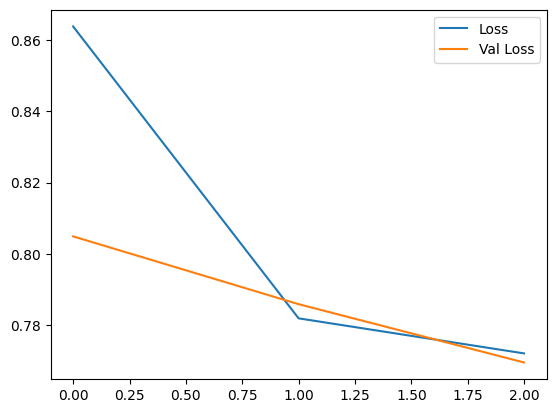

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Affichage de l'image 0 avec /content/drive/My Drive/Colab Notebooks/colorisation/test_color/image5000.jpg


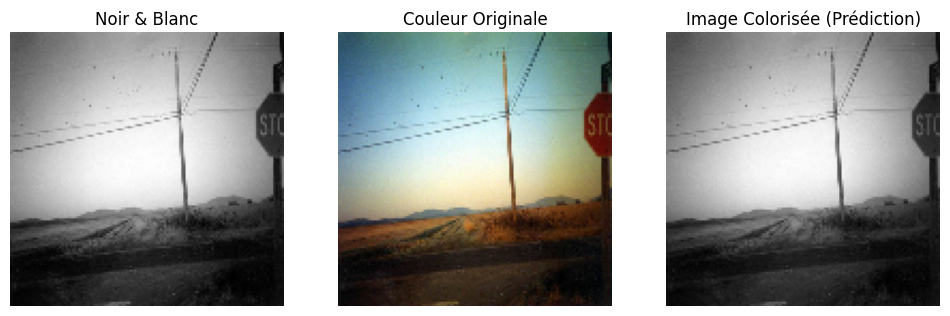

Affichage de l'image 1 avec /content/drive/My Drive/Colab Notebooks/colorisation/test_color/image5001.jpg


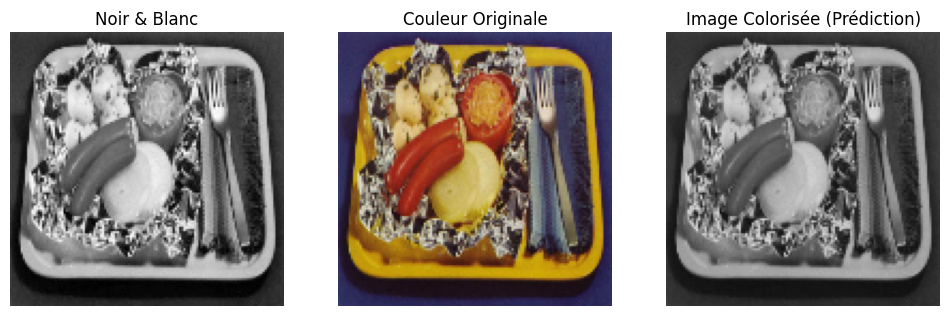

Affichage de l'image 2 avec /content/drive/My Drive/Colab Notebooks/colorisation/test_color/image5002.jpg


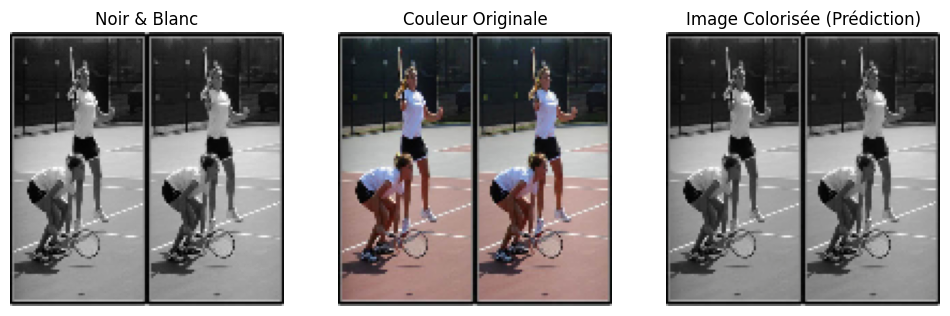

Affichage de l'image 3 avec /content/drive/My Drive/Colab Notebooks/colorisation/test_color/image5003.jpg


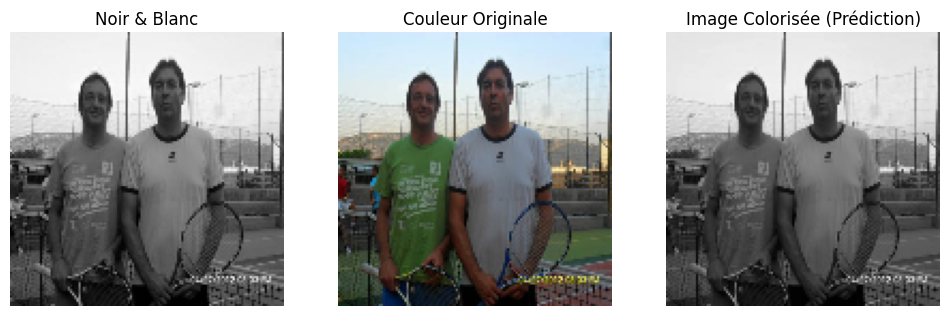

Affichage de l'image 4 avec /content/drive/My Drive/Colab Notebooks/colorisation/test_color/image5004.jpg


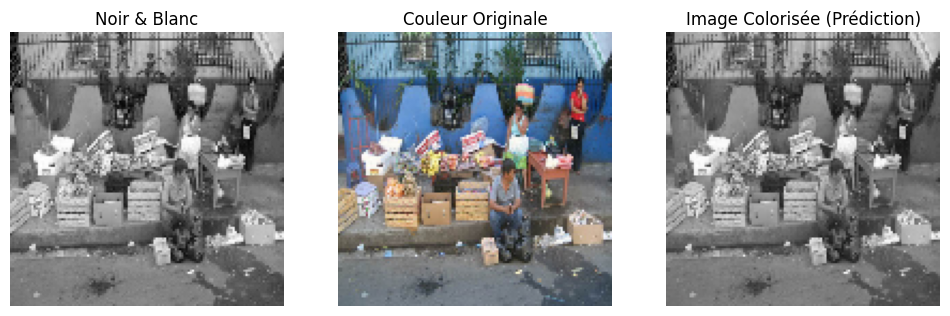

In [ ]:
color_test_images = [os.path.join(COLOR_TEST_PATH, f) for f in os.listdir(COLOR_TEST_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
color_test_images.sort()

def visualize_predictions(model, X_test, Y_test, color_test_images, max_images=5):
    max_images = min(max_images, len(X_test), len(color_test_images))
    predictions = model.predict(X_test[:max_images])

    predictions = predictions * 128
    predictions = predictions + 128
    predictions = np.clip(predictions, -128, 127).astype(np.int8)

    for i in range(max_images):
        print(f"Affichage de l'image {i} avec {color_test_images[i]}")

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i], cmap='gray')
        plt.title('Noir & Blanc')
        plt.axis('off')

        original_image = cv2.imread(color_test_images[i])
        original_image_resized = cv2.resize(original_image, (IMG_WIDTH, IMG_HEIGHT))
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(original_image_resized, cv2.COLOR_BGR2RGB))
        plt.title('Couleur Originale')
        plt.axis('off')

        # Reconstruction de l'image colorisée
        lab_pred = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        lab_pred[:, :, 0] = np.squeeze(X_test[i]) * 255
        lab_pred[:, :, 1:] = predictions[i] * 128

        # Convertir Lab en RGB
        colorized_image = cv2.cvtColor(lab_pred.astype(np.uint8), cv2.COLOR_Lab2BGR)

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(colorized_image, cv2.COLOR_BGR2RGB))
        plt.title('Image Colorisée (Prédiction)')
        plt.axis('off')

        plt.show()

visualize_predictions(model, X_test, Y_test, color_test_images, max_images=5)

# Résolution

# Preprocessing

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Taille des images
BATCH_SIZE = 16

def load_images(LR_path, HR_path, max_images=None):
    LR_images, HR_images = [], []

    LR_files = sorted([f for f in os.listdir(LR_path) if f.endswith(('png', 'jpg'))])
    HR_files = sorted([f for f in os.listdir(HR_path) if f.endswith(('png', 'jpg'))])

    if len(LR_files) != len(HR_files):
        raise ValueError(f"Le nombre d'images LR ({len(LR_files)}) et d'images HR ({len(HR_files)}) ne correspond pas.")

    for lr_file, hr_file in zip(LR_files[:max_images], HR_files[:max_images]):
        lr_img = cv2.imread(os.path.join(LR_path, lr_file))
        hr_img = cv2.imread(os.path.join(HR_path, hr_file))

        if lr_img is not None and hr_img is not None:
            lr_img_resized = cv2.resize(lr_img, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
            hr_img_resized = cv2.resize(hr_img, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
            LR_images.append(lr_img_resized)
            HR_images.append(hr_img_resized)

    return np.array(LR_images), np.array(HR_images)

print("Chargement des données...")
X_train, Y_train = load_images(LR_TRAIN_PATH, HR_TRAIN_PATH, max_images=1000)
X_valid, Y_valid = load_images(LR_VALID_PATH, HR_VALID_PATH, max_images=200)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, Y_valid shape: {Y_valid.shape}")

Chargement des données...
X_train shape: (800, 128, 128, 3), Y_train shape: (800, 128, 128, 3)
X_valid shape: (100, 128, 128, 3), Y_valid shape: (100, 128, 128, 3)


# Construction du modèle

In [ ]:
# Construction du modèle
model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),

    layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_12 (UpSampling2D)      │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_13 (UpSampling2D)      │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_14 (UpSampling2D)      │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 128, 128, 3)         │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,163,779 (23.51 MB)

 Trainable params: 6,163,779 (23.51 MB)

 Non-trainable params: 0 (0.00 B)

# Entraînement du modèle

In [ ]:
# Entraînement du modèle
print("Entraînement du modèle...")
history = model.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=3,
    batch_size=BATCH_SIZE
)

Entraînement du modèle...
Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.4278 - loss: 0.0719 - val_accuracy: 0.4852 - val_loss: 0.0394
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.5228 - loss: 0.0360 - val_accuracy: 0.5512 - val_loss: 0.0287
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.6183 - loss: 0.0271 - val_accuracy: 0.6512 - val_loss: 0.0260


# Visualisation

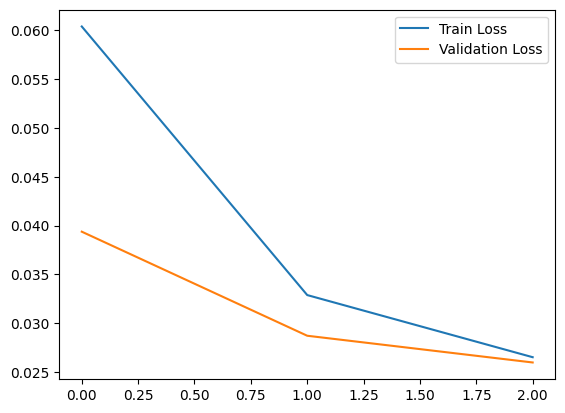

In [ ]:
# Visualisation de la courbe d'apprentissage
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Comparaison des résultats...


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


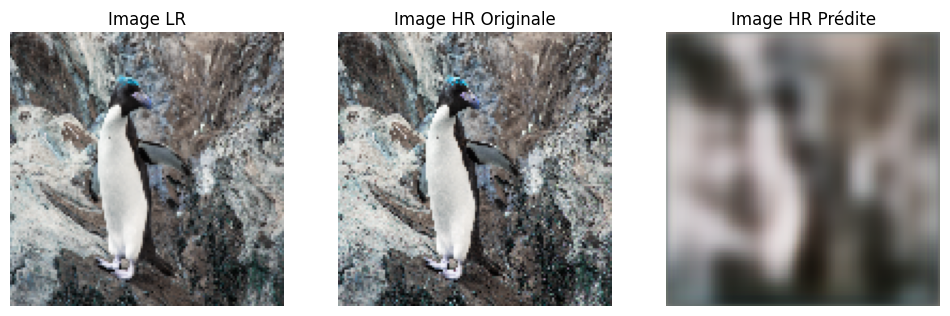

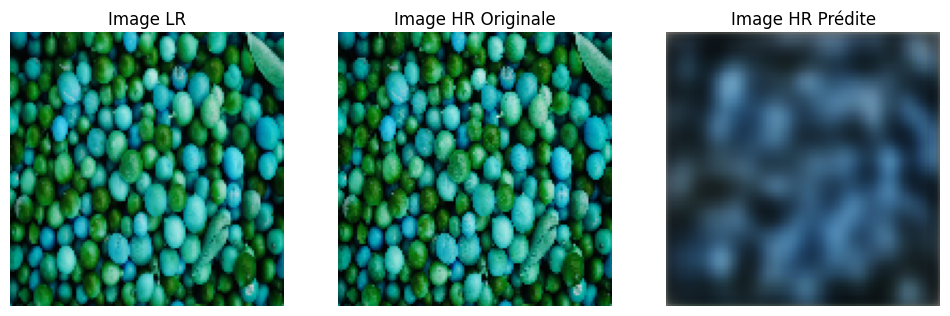

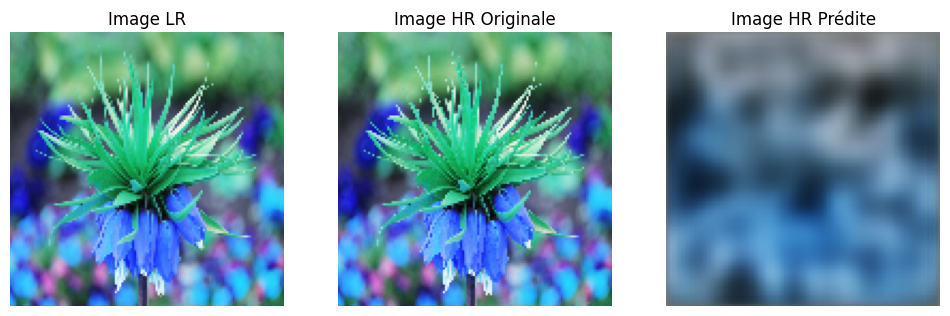

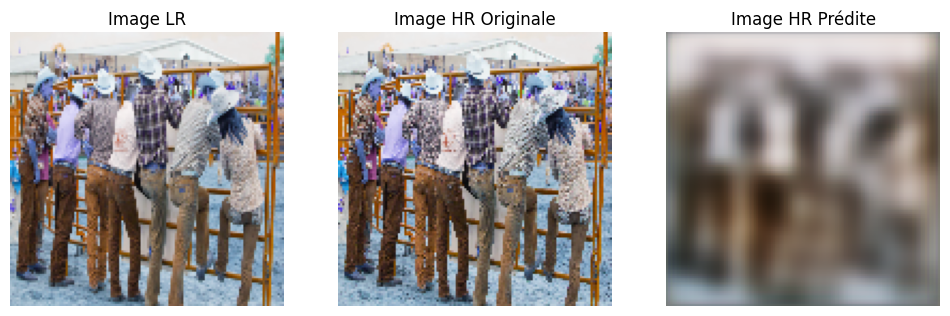

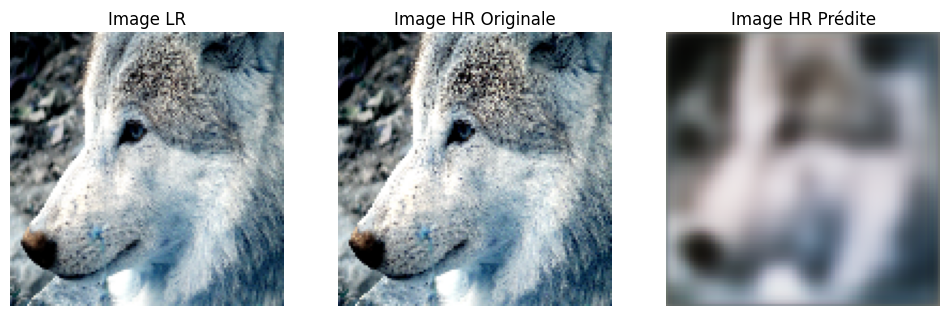

In [ ]:
# Fonction pour visualiser les résultats
def visualize_results(model, lr_images, hr_images, num_results=5):
    predictions = model.predict(lr_images)

    for i in range(min(num_results, len(lr_images))):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(lr_images[i])
        plt.title('Image LR')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(hr_images[i])
        plt.title('Image HR Originale')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i])
        plt.title('Image HR Prédite')
        plt.axis('off')

        plt.show()

print("Comparaison des résultats...")
visualize_results(model, X_valid, Y_valid, num_results=5)

# VGG

# Colorisation

# Preprocessing

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 1000
MAX_TEST_IMAGES = 200

# Fonction de prétraitement des images
def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image_rgb = np.repeat(gray_image[:, :, np.newaxis], 3, axis=2)
    gray_image_rgb_resized = cv2.resize(gray_image_rgb, (IMG_WIDTH, IMG_HEIGHT))
    return gray_image_rgb_resized / 255.0

# Fonction pour charger et prétraiter les images
def load_images(image_paths, max_images):
    images = []
    for path in image_paths[:max_images]:
        img = cv2.imread(path)
        if img is not None:
            img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            images.append(img_resized / 255.0)
    return np.array(images)

black_train_files = sorted(os.listdir(BLACK_TRAIN_PATH))
color_train_files = sorted(os.listdir(COLOR_TRAIN_PATH))
black_test_files = sorted(os.listdir(BLACK_TEST_PATH))
color_test_files = sorted(os.listdir(COLOR_TEST_PATH))

print("Chargement des données...")

# Liste des chemins des images
black_train_images = [os.path.join(BLACK_TRAIN_PATH, f) for f in black_train_files[:MAX_TRAIN_IMAGES]]
color_train_images = [os.path.join(COLOR_TRAIN_PATH, f) for f in color_train_files[:MAX_TRAIN_IMAGES]]

black_test_files = sorted(os.listdir(BLACK_TEST_PATH))
color_test_files = sorted(os.listdir(COLOR_TEST_PATH))

black_test_images = [os.path.join(BLACK_TEST_PATH, f) for f in black_test_files[:MAX_TEST_IMAGES]]
color_test_images = [os.path.join(COLOR_TEST_PATH, f) for f in color_test_files[:MAX_TEST_IMAGES]]

# Chargement des images
X_train = load_images(black_train_images, MAX_TRAIN_IMAGES)
Y_train = load_images(color_train_images, MAX_TRAIN_IMAGES)
X_test = load_images(black_test_images, MAX_TEST_IMAGES)
Y_test = load_images(color_test_images, MAX_TEST_IMAGES)

# Vérification des dimensions
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

Chargement des données...
X_train shape: (1000, 128, 128, 3), Y_train shape: (1000, 128, 128, 3)
X_test shape: (200, 128, 128, 3), Y_test shape: (200, 128, 128, 3)


#Construction du modèle

In [ ]:
print("Construction du modèle...")
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.UpSampling2D(size=(2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(size=(2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(size=(2, 2)),
    layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['accuracy'])
model.summary()

Construction du modèle...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_9 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,282,755 (62.11 MB)

 Trainable params: 1,568,067 (5.98 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Entraînement

In [ ]:
vgg_encoder = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
vgg_model = models.Model(inputs=vgg_encoder.input, outputs=vgg_encoder.get_layer('block3_conv3').output)

def perceptual_loss(y_true, y_pred):
    true_features = vgg_model(y_true)
    pred_features = vgg_model(y_pred)
    loss_mse = tf.reduce_mean(tf.square(y_true - y_pred))
    loss_perceptual = tf.reduce_mean(tf.square(true_features - pred_features))
    return loss_mse + 0.1 * loss_perceptual

# Compilation et entraînement du modèle
print("Compilation du modèle...")
model.compile(optimizer=Adam(learning_rate=1e-4), loss=perceptual_loss, metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=Y_train,
    validation_data=(X_test, Y_test),
    epochs=3,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(X_train) // BATCH_SIZE
)

Compilation du modèle...
Epoch 1/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 805s 13s/step - accuracy: 0.3626 - loss: 6.0312 - val_accuracy: 0.4482 - val_loss: 5.5088
Epoch 2/3
 1/62 ━━━━━━━━━━━━━━━━━━━━ 6:30 6s/step - accuracy: 0.5473 - loss: 5.4564

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


62/62 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.5473 - loss: 5.4564 - val_accuracy: 0.4420 - val_loss: 5.5035
Epoch 3/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 874s 14s/step - accuracy: 0.4290 - loss: 5.3206 - val_accuracy: 0.4554 - val_loss: 5.3649


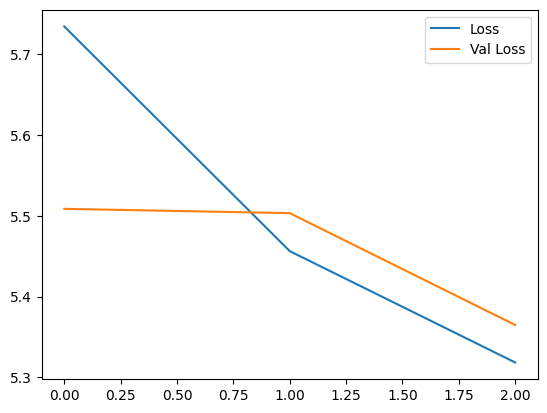

In [ ]:
# Visualisation des performances
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

#Visualisation

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


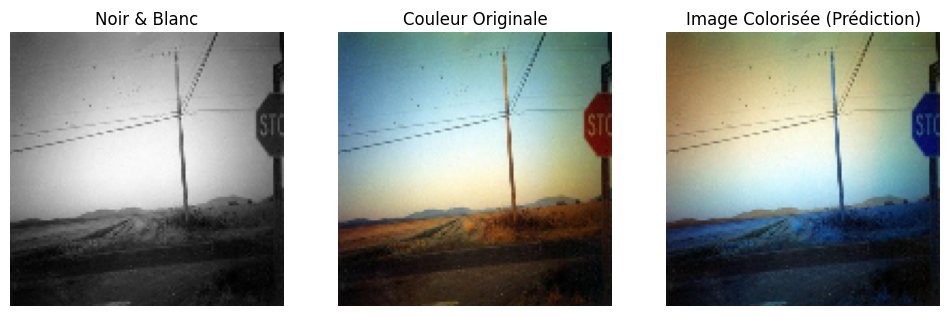

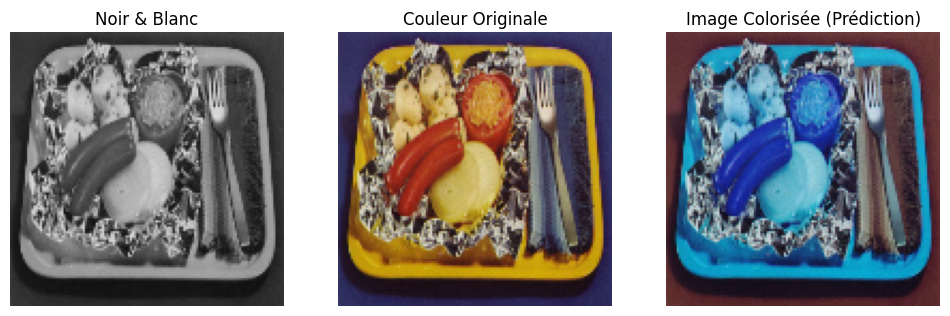

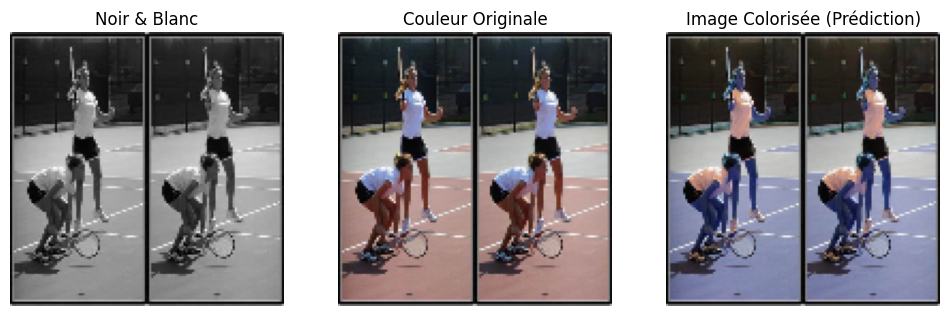

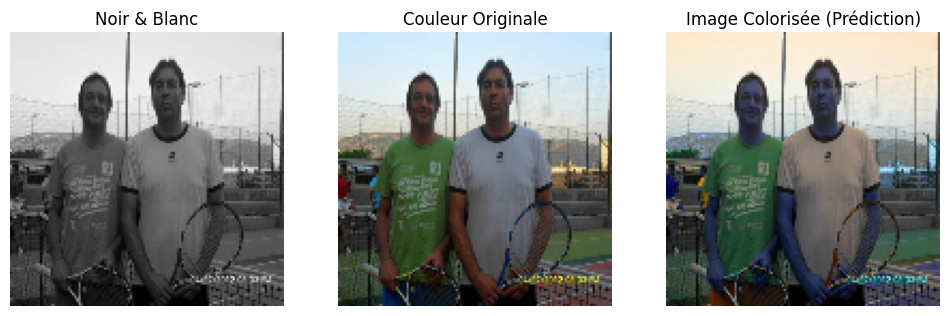

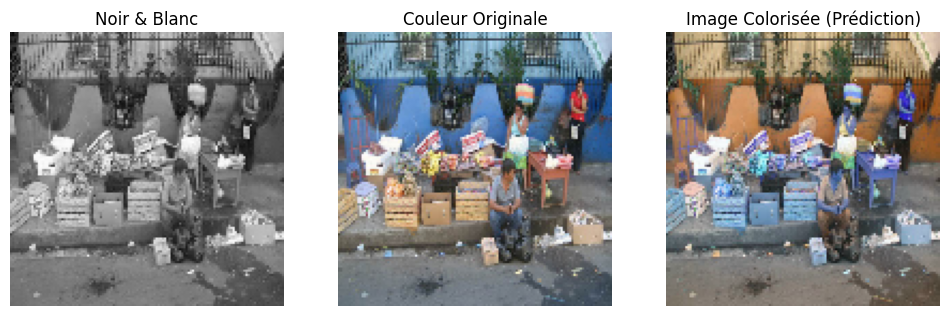

In [ ]:
def visualize_predictions(model, X_test, Y_test, color_test_images, max_images=5):
    predictions = model.predict(X_test[:max_images])
    predictions = predictions * 255  # Dénormalisation
    predictions = np.clip(predictions, 0, 255).astype(np.uint8)

    for i in range(max_images):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i], cmap='gray')
        plt.title('Noir & Blanc')
        plt.axis('off')

        original_image = cv2.imread(color_test_images[i])
        original_image_resized = cv2.resize(original_image, (IMG_WIDTH, IMG_HEIGHT))
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(original_image_resized, cv2.COLOR_BGR2RGB))
        plt.title('Couleur Originale')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(Y_test[i])
        plt.title('Image Colorisée (Prédiction)')
        plt.axis('off')

        plt.show()

visualize_predictions(model, X_test, Y_test, color_test_images, max_images=5)

# Résolution

#Preprocessing

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt

# Paramètres globaux
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Taille des images
BATCH_SIZE = 16

def load_images(LR_path, HR_path, max_images=None):
    LR_images, HR_images = [], []

    LR_files = sorted([f for f in os.listdir(LR_path) if f.endswith(('png', 'jpg'))])
    HR_files = sorted([f for f in os.listdir(HR_path) if f.endswith(('png', 'jpg'))])

    if len(LR_files) != len(HR_files):
        raise ValueError(f"Le nombre d'images LR ({len(LR_files)}) et d'images HR ({len(HR_files)}) ne correspond pas.")

    for lr_file, hr_file in zip(LR_files[:max_images], HR_files[:max_images]):
        lr_img = cv2.imread(os.path.join(LR_path, lr_file))
        hr_img = cv2.imread(os.path.join(HR_path, hr_file))

        if lr_img is not None and hr_img is not None:
            lr_img_resized = cv2.resize(lr_img, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
            hr_img_resized = cv2.resize(hr_img, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
            LR_images.append(lr_img_resized)
            HR_images.append(hr_img_resized)

    return np.array(LR_images), np.array(HR_images)

print("Chargement des données...")
X_train, Y_train = load_images(LR_TRAIN_PATH, HR_TRAIN_PATH, max_images=1000)
X_valid, Y_valid = load_images(LR_VALID_PATH, HR_VALID_PATH, max_images=200)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, Y_valid shape: {Y_valid.shape}")

# Fonction de loss perceptuelle basée sur VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
vgg_model.trainable = False
perceptual_layer = models.Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block3_conv3').output)

def perceptual_loss(y_true, y_pred):
    y_true_resized = tf.image.resize(y_true, (IMG_HEIGHT, IMG_WIDTH))
    y_pred_resized = tf.image.resize(y_pred, (IMG_HEIGHT, IMG_WIDTH))

    true_features = perceptual_layer(y_true_resized)
    pred_features = perceptual_layer(y_pred_resized)

    loss_mse = tf.reduce_mean(tf.square(y_true_resized - y_pred_resized))
    loss_perceptual = tf.reduce_mean(tf.square(true_features - pred_features))
    return loss_mse + 0.1 * loss_perceptual

Chargement des données...
X_train shape: (800, 128, 128, 3), Y_train shape: (800, 128, 128, 3)
X_valid shape: (100, 128, 128, 3), Y_valid shape: (100, 128, 128, 3)


#Construction du modèle

In [ ]:
print("Construction du modèle...")
model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=1e-4), loss=perceptual_loss, metrics=['accuracy'])
model.summary()

Construction du modèle...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 128, 128, 3)         │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 263,619 (1.01 MB)

 Trainable params: 263,619 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

# Entraînement du modèle

In [ ]:
print("Entraînement du modèle...")
history = model.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=3,
    batch_size=BATCH_SIZE
)

Entraînement du modèle...
Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 1002s 20s/step - accuracy: 0.5187 - loss: 5.1108 - val_accuracy: 0.6929 - val_loss: 2.4232
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 1012s 20s/step - accuracy: 0.7539 - loss: 1.9812 - val_accuracy: 0.7907 - val_loss: 1.0541
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 1027s 21s/step - accuracy: 0.7849 - loss: 0.9115 - val_accuracy: 0.7683 - val_loss: 0.6334


# Visualisation

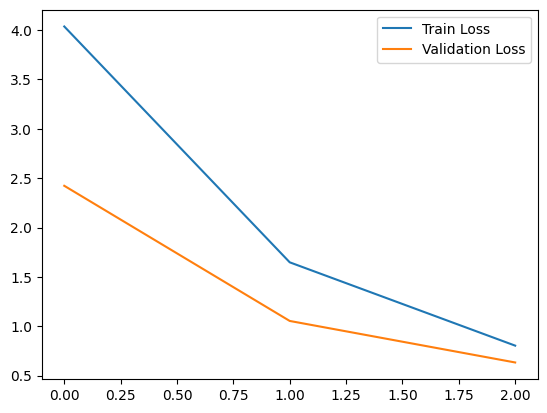

In [ ]:
# Visualisation de la courbe d'apprentissage
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Comparaison des résultats...
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step


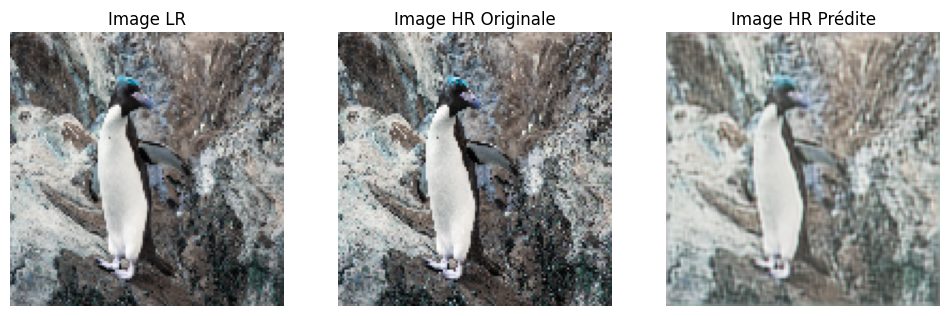

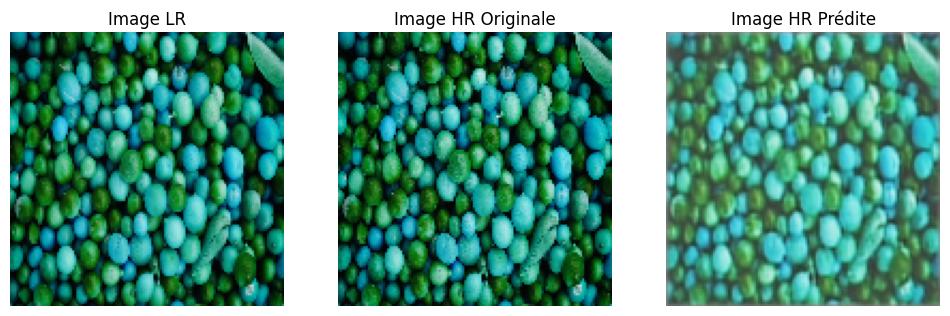

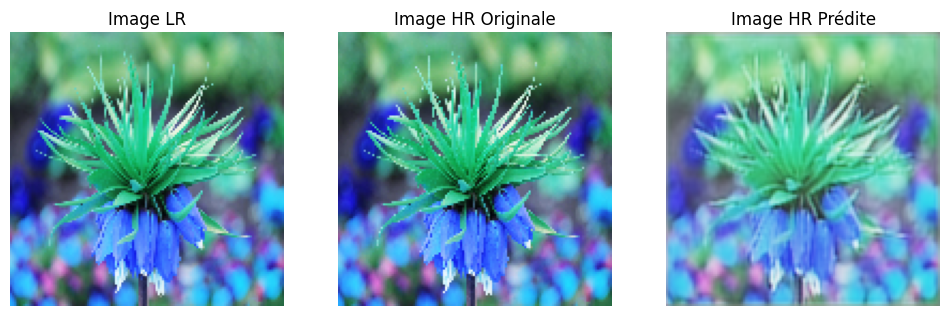

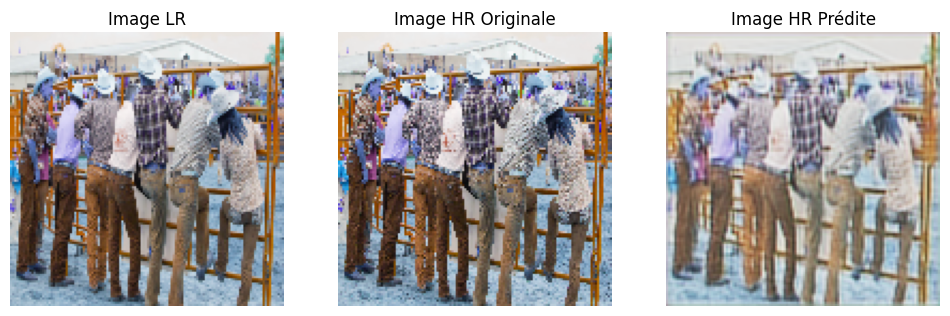

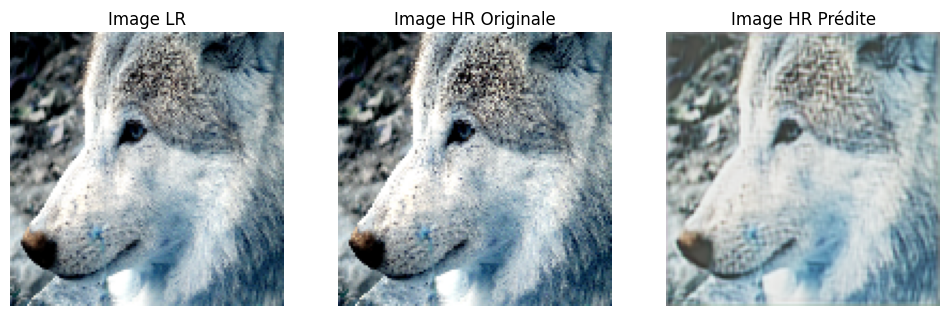

In [ ]:
def visualize_results(model, lr_images, hr_images, num_results=5):
    predictions = model.predict(lr_images)

    for i in range(min(num_results, len(lr_images))):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(lr_images[i])
        plt.title('Image LR')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(hr_images[i])
        plt.title('Image HR Originale')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i])
        plt.title('Image HR Prédite')
        plt.axis('off')

        plt.show()

print("Comparaison des résultats...")
visualize_results(model, X_valid, Y_valid, num_results=5)